In [1]:
# import modules
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import zipfile
from zipfile import ZipFile
from urllib.request import urlopen   
from sklearn.model_selection import GroupShuffleSplit
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


r_seed = 42

np.random.seed(r_seed)
tf.random.set_seed(r_seed)

In [2]:
## get dataset

URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00344/Activity%20recognition%20exp.zip'

# open and save the zip file 
url = urlopen(URL)
output = open('Activity recognition exp.zip', 'wb')            
output.write(url.read())
output.close()


zf = zipfile.ZipFile('Activity recognition exp.zip') 
## select only sensor data from smart watches
data = pd.read_csv(zf.open('Activity recognition exp/Watch_accelerometer.csv'))

del output

In [ ]:
data.shape

(3540962, 10)

In [ ]:
data.head()

,Index,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
0,0,1424696638740,27920678471000,-0.565032,-9.572019,-0.614113,a,gear,gear_1,stand
1,1,1424696638740,27920681910000,-0.832584,-9.713276,-0.606930,a,gear,gear_1,stand
2,2,1424696638740,27920692014000,-1.018134,-9.935339,-0.544082,a,gear,gear_1,stand
3,3,1424696638741,27920701983000,-1.222838,-10.142437,-0.566229,a,gear,gear_1,stand
4,4,1424696638741,27920711906000,-1.577180,-10.480618,-0.402824,a,gear,gear_1,stand


In [ ]:
data['gt'].isnull().sum()

520357

In [3]:
#remove the null class
data=data.dropna()

# **Data Exploration**

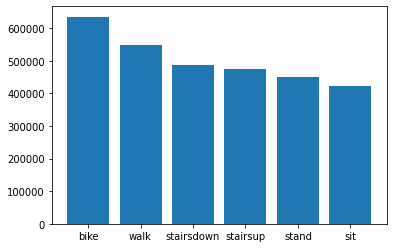

In [ ]:
## the distribution of output classes
plt.bar(data["gt"].value_counts().index, data["gt"].value_counts().values)
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ceb90d4a8>,
      dtype=object)

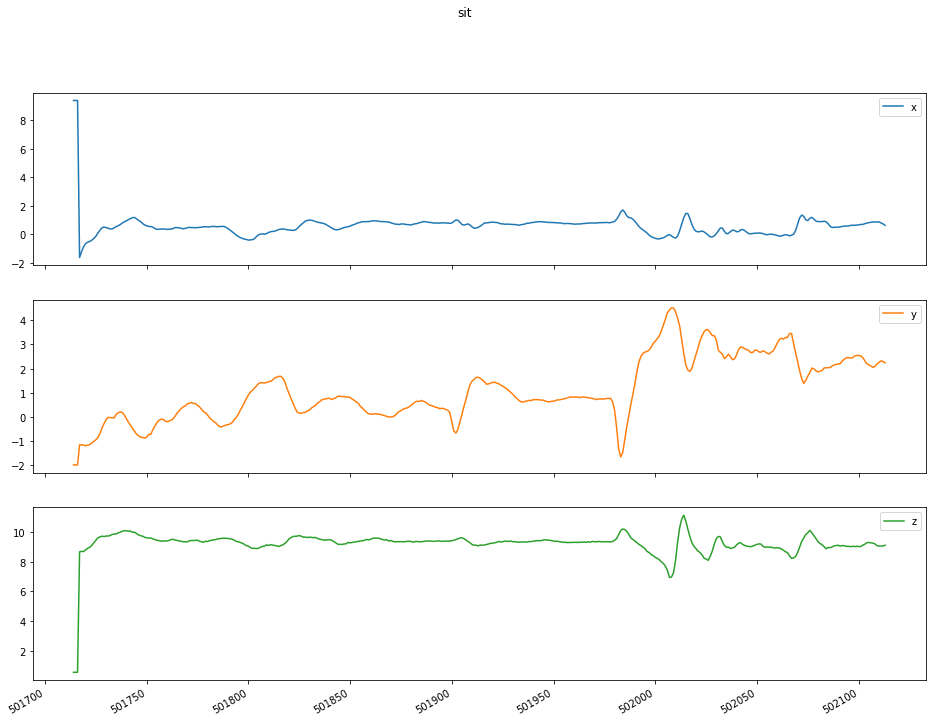

In [ ]:
## x,y,z vaues for activity 'sit' 
data[(data['gt'] == 'sit')&(data['User']=='b')][['x', 'y', 'z']][:400].plot(title='sit',subplots=True, figsize=(16, 12))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ceb76bda0>,
      dtype=object)

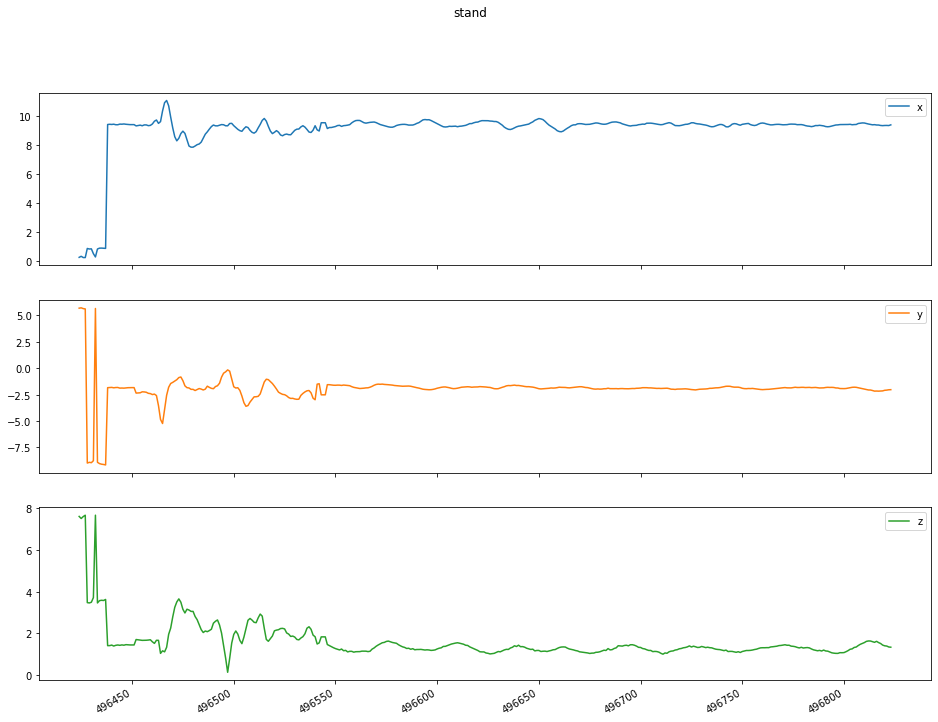

In [ ]:
## x,y,z vaues for activity 'stand' 
data[(data['gt'] == 'stand')&(data['User']=='b')][['x', 'y', 'z']][:400].plot(title='stand',subplots=True, figsize=(16, 12))

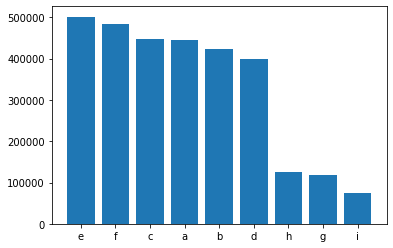

In [ ]:
## number of events per user

plt.bar(data["User"].value_counts().index, data["User"].value_counts().values)
plt.show()

# **Models**

In [4]:
## test-train split by keeping 80% for training and 20% for testing


## random split of the data for train-test
df_train,df_test=train_test_split(data, test_size = 0.20, random_state = r_seed)



df_train=df_train[['x','y','z','gt']]
df_test=df_test[['x','y','z','gt']]

## scale x,y,z columns 
feat_cols = ['x', 'y', 'z']
scale = RobustScaler().fit(df_train[feat_cols])
df_train.loc[:, feat_cols] = scale.transform(df_train[feat_cols].to_numpy())
df_test.loc[:, feat_cols] = scale.transform(df_test[feat_cols].to_numpy())

In [6]:
## create input time sequences and take labels of frequently occuring class in the sequence
## hot encode the target variable

def input_seq(X, Y, timesteps):
    Xin, Yin = [], []
    for i in range(0, len(X) - timesteps):
        v = X.iloc[i:(i + timesteps)].values
        labels = Y.iloc[i: i + timesteps]
        Xin.append(v)        
        Yin.append(stats.mode(labels)[0][0])
    return np.array(Xin), np.array(Yin).reshape(-1, 1)


X_tr, Y_tr = input_seq(df_train[['x', 'y', 'z']], df_train['gt'], 300)
X_te, Y_te = input_seq(df_test[['x', 'y', 'z']], df_test['gt'], 300)

hotenc=OneHotEncoder(handle_unknown='ignore', sparse=False)
hotenc= hotenc.fit(Y_tr)
Y_tr = hotenc.transform(Y_tr)
Y_te = hotenc.transform(Y_te)





In [7]:
X_tr.shape

(483237, 300, 3)

In [8]:
Y_tr.shape

(483237, 6)

In [ ]:
# create and fit the SimpleRNN model
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(units=32, input_shape=(X_tr.shape[1], 
    X_tr.shape[2])))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(Y_tr.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history=model.fit(X_tr, Y_tr, epochs=20, batch_size=128,validation_split=0.2,shuffle=False)

In [ ]:
## test set accuracy
model.evaluate(X_te, Y_te)

In [ ]:
## LSTM
model = keras.Sequential()
model.add(keras.layers.LSTM(units=32,input_shape=[X_tr.shape[1], X_tr.shape[2]]))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(Y_tr.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
#print(model.summary())
history=model.fit(X_tr, Y_tr, epochs=20, batch_size=128,validation_split=0.2,shuffle=False)

In [ ]:
## test set accuracy
model.evaluate(X_te, Y_te)

In [ ]:
## GRU
model = keras.Sequential()

model.add(keras.layers.GRU(units=32,input_shape=[X_tr.shape[1], X_tr.shape[2]]))

model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(Y_tr.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
#print(model.summary())
history=model.fit(X_tr, Y_tr, epochs=20, batch_size=128,validation_split=0.2,shuffle=False)

Epoch 1/20
3021/3021 [==============================] - 44s 14ms/step - loss: 0.8903 - acc: 0.7340 - val_loss: 0.8668 - val_acc: 0.7267
Epoch 2/20
3021/3021 [==============================] - 42s 14ms/step - loss: 0.8419 - acc: 0.7370 - val_loss: 0.8283 - val_acc: 0.7267
Epoch 3/20
3021/3021 [==============================] - 42s 14ms/step - loss: 0.8165 - acc: 0.7384 - val_loss: 0.8135 - val_acc: 0.7272
Epoch 4/20
3021/3021 [==============================] - 42s 14ms/step - loss: 0.8059 - acc: 0.7394 - val_loss: 0.8049 - val_acc: 0.7284
Epoch 5/20
3021/3021 [==============================] - 42s 14ms/step - loss: 0.7986 - acc: 0.7403 - val_loss: 0.7979 - val_acc: 0.7302
Epoch 6/20
3021/3021 [==============================] - 42s 14ms/step - loss: 0.7914 - acc: 0.7416 - val_loss: 0.7910 - val_acc: 0.7330
Epoch 7/20
3021/3021 [==============================] - 42s 14ms/step - loss: 0.7856 - acc: 0.7428 - val_loss: 0.7859 - val_acc: 0.7342
Epoch 8/20
3021/3021 [==========================

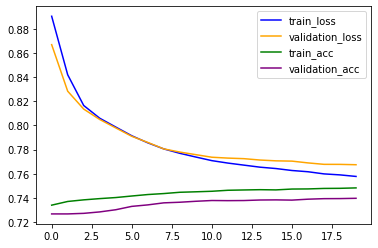

In [ ]:
plt.plot(history.history['loss'], label='train_loss',color='blue')
plt.plot(history.history['val_loss'], label='validation_loss',color='orange')
plt.plot(history.history['acc'], label='train_acc',color='green')
plt.plot(history.history['val_acc'], label='validation_acc',color='purple')
plt.legend()

In [ ]:
model.evaluate(X_te, Y_te)

3774/3774 [==============================] - 23s 6ms/step - loss: 0.7457 - acc: 0.7456


[0.7456637620925903, 0.7455968260765076]